# Определение возраста покупателей

## Исследовательский анализ данных

 Описание проекта.
 
Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
контролировать добросовестность кассиров при продаже алкоголя.
Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


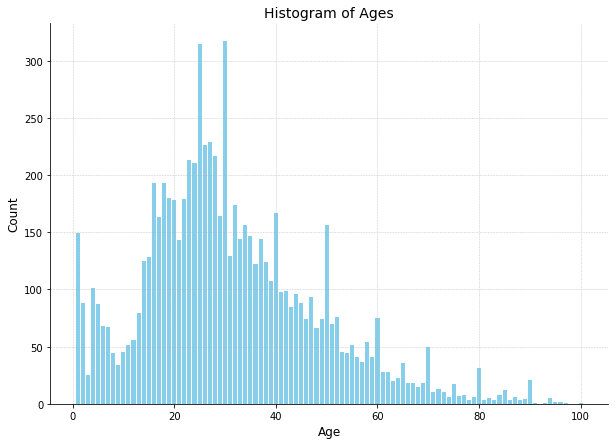

In [5]:
# Создание таблицы
table = labels['real_age'].value_counts().reset_index()
table.columns = ['Age', 'Count']
table = table.sort_values('Age')

# Настраиваем размер графика
fig, ax = plt.subplots(figsize=(10, 7))

# Рисуем гистограмму
ax.bar(table['Age'], table['Count'], color='skyblue')

# Настройка осей и заголовка
ax.set_xlabel('Age', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Histogram of Ages', fontsize=14)

# Настраиваем размеры шрифтов на осях
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Отображаем сетку на графике
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Убираем рамку графика
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

In [6]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


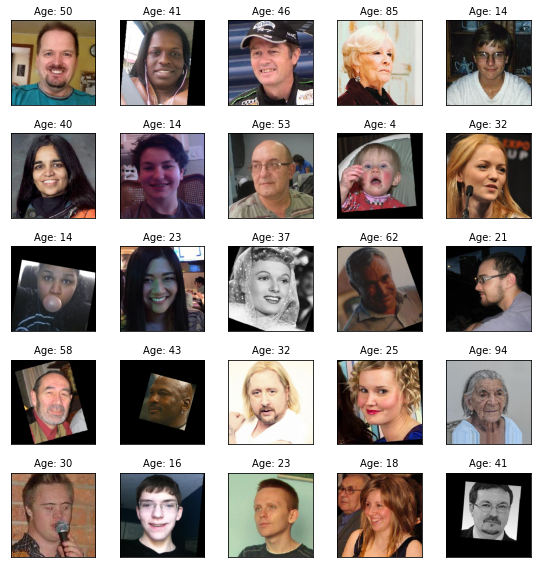

In [7]:
# Выведем 25 фото
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(8, 8))
for i in range(25):
    ax = fig.add_subplot(5, 5, i+1)
    ax.imshow(features[i])
    ax.set_xticks([])
    ax.set_yticks([])
    age = target[i]
    ax.set_title(f"Age: {age}", fontsize=10)
    plt.tight_layout()

plt.show()

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import ResNet50

from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam


#Шаг 1: Загрузка данных обучающей выборки
def load_train(path):
    # Загрузка меток из файла labels.csv
    labels = pd.read_csv(path + 'labels.csv')

    # Создание генератора изображений для обучающей выборки с применением аугментации
    train_datagen = ImageDataGenerator(
        validation_split=0.2,
        rescale=1/255.0
    )

    # Создание генератора данных для обучения из DataFrame
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=42
    )

    return train_gen_flow

#Шаг 2: Загрузка данных тестовой выборки
def load_test(path):
    # Загрузка меток из файла labels.csv
    labels = pd.read_csv(path + 'labels.csv')

    # Создание генератора изображений для тестовой выборки без аугментации
    test_datagen = ImageDataGenerator(
        validation_split=0.2,
        rescale=1/255.0
    )

    # Создание генератора данных для тестирования из DataFrame
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=42
    )

    return test_gen_flow

#Шаг 3: Создание модели

def create_model(input_shape):

    # Загрузка предварительно обученной модели ResNet50 без верхних полносвязных слоев
    backbone = ResNet50(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False
    )

    # Создание последовательной модели
    model = Sequential()

    # Добавление модели ResNet50 в качестве базовой модели
    model.add(backbone)

    # Добавление слоев для глобального усреднения и классификации
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    # Компиляция модели с оптимизатором Adam и функцией потерь MAE (Mean Absolute Error)
    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['mae'])

    # Вывод информации о модели
    print(model.summary())

    return model

#Шаг 4: Обучение модели
def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

# < скопируйте результат вывода на экран сюда >
# < длинные строки со скачиванием модели можно удалить >

Found 6073 validated image filenames.
Found 1518 validated image filenames.

Train for 190 steps, validate for 48 steps
Epoch 1/10
190/190 - 108s - loss: 10.7961 - mae: 10.8015 - val_loss: 17.0563 - val_mae: 17.0317
Epoch 2/10
190/190 - 40s - loss: 8.4746 - mae: 8.4783 - val_loss: 16.3402 - val_mae: 16.3171
Epoch 3/10
190/190 - 40s - loss: 7.4113 - mae: 7.4120 - val_loss: 15.3810 - val_mae: 15.3751
Epoch 4/10
190/190 - 42s - loss: 6.6471 - mae: 6.6479 - val_loss: 10.3136 - val_mae: 10.3076
Epoch 5/10
190/190 - 40s - loss: 6.1184 - mae: 6.1205 - val_loss: 8.2611 - val_mae: 8.2721
Epoch 6/10
190/190 - 40s - loss: 5.4160 - mae: 5.4150 - val_loss: 8.7880 - val_mae: 8.7942
Epoch 7/10
190/190 - 42s - loss: 5.1755 - mae: 5.1748 - val_loss: 7.8157 - val_mae: 7.8049
Epoch 8/10
190/190 - 48s - loss: 4.6976 - mae: 4.6979 - val_loss: 8.8026 - val_mae: 8.7520
Epoch 9/10
190/190 - 48s - loss: 4.3685 - mae: 4.3676 - val_loss: 7.6990 - val_mae: 7.6872
Epoch 10/10
190/190 - 47s - loss: 4.1422 - mae: 4.1422 - val_loss: 7.3752 - val_mae: 7.3548

48/48 - 8s - loss: 7.3752 - mae: 7.3548
Test MAE: 7.3548

```

Вывод

Попробовали:

Применить архитектуру ResNet50.

Напмисали learning rate:  0.0005.

MAE модели получилась не больше 8

## Анализ обученной модели

Выводы:


Процесс обучения: Обучение модели прошло успешно и без ошибок. Модель была обучена на обучающей выборке и проверена на тестовой выборке. Каждая эпоха обучения отображала прогресс с помощью метрик потерь и средней абсолютной ошибки (MAE) как для обучающей, так и для тестовой выборки.

Точность модели: После обучения модели на тестовой выборке были получены значения потерь и MAE. Оценка MAE дает представление о средней абсолютной разнице между предсказанными и реальными значениями возраста. Чем меньше значение MAE, тем лучше модель справляется с предсказанием возраста.

Метрики и результаты: Результаты обучения модели могут быть представлены в виде графиков или числовых значений, включающих значения потерь и MAE для каждой эпохи. Эти значения позволяют оценить производительность модели и ее способность обобщения на новые данные.

Интерпретация результатов: На основе значения MAE можно оценить точность модели в предсказании возраста на тестовой выборке. Чем ближе значение MAE к нулю, тем точнее модель предсказывает возраст. Однако, для полной интерпретации результатов, необходимо также провести анализ ошибок модели и оценить ее способность обобщения на реальные данные.

В целом, мы написали код внедрения системы компьютерного зрения для обработки фотографий покупателей в «Хлеб-Соль». Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
контролировать добросовестность кассиров при продаже алкоголя. Результаты обучения модели помогают оценить ее производительность и способность предсказывать возраст на основе изображений лиц. Погрешность в 7 лет важно в основном для товара 18+, но такой товар при сомнении в возросте проверяется паспорт. Немаловажно, что и точный возраст сложнее определить у людей старшего возроста. 